### Creating Model 3

* Creating a 3rd model for the NFL Play data. The goal is to predict the play type on 4th down.
* Logistic Regression & Random Forest have been completed, so the next step is gradient boosted trees.

In [15]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
import nfl_data_py as nfl
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN
from DataPipelineFxn import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [2]:
# get the spark session and data frame
spark, df, test_df = GetSparkDF(undersample = False)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 11:02:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Create the Model Pipeline

In [4]:
from pyspark.ml.classification import NaiveBayes

In [5]:
str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half",
        "play_type", "season", 'roof', 'surface']
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx",
                  "side_of_field_idx", "game_half_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec",
                  "side_of_field_vec", "game_half_ivec", "season_vec", 'roof_vec', 'surface_vec']


# process using string indexer first for catgeorical features  
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# process rating data into second feature
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec) 

# Assemble features column
va = VectorAssembler(inputCols=ohe_col_vec, outputCol="features") 

# process data using maxabs scaler, not necessarily important for trees but consistency
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

# define the model
nb = NaiveBayes(
    featuresCol = 'features', labelCol = 'play_type_idx'
)

# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler, nb])

In [ ]:
# help(gbt)

In [6]:
# hyperparameter search across max depth, bins, and iterations
# paramGrid = ParamGridBuilder()\
#     .addGrid(gbt.maxDepth, np.arange(10, 100, step = 10)) \
#     .addGrid(gbt.maxIter, [20, 50, 100, 200])\
#     .addGrid(gbt.maxBins, np.arange(10, 100, step = 10))\
#     .build()

paramGrid = ParamGridBuilder()\
    .addGrid(nb.smoothing, np.arange(0.05, 1, step = 0.05)) \
    .build()

# build the evaluator
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="play_type_idx",
    metricName="accuracy"
)

# set up the train validation split
tvs = TrainValidationSplit(
    estimator=pipeline,
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8
)

In [21]:
# need to replace the empty string in surface
df = df.withColumn(
    'surface',
    F.when(df.surface == '', 'Undefined').otherwise(df.surface)
)

# fit the model with the hyperparameter search
nb_model = tvs.fit(df)

24/12/02 11:11:39 WARN TaskSetManager: Stage 76 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:11:40 WARN TaskSetManager: Stage 79 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:11:42 WARN TaskSetManager: Stage 82 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:11:43 WARN TaskSetManager: Stage 85 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:11:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/02 11:11:44 WARN TaskSetManager: Stage 87 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:11:45 WARN TaskSetManager: Stage 90 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:11:46 WARN TaskSetManager: St

### Evaluate the Model

In [22]:
best_model = nb_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Parameters of the Best Model:
featuresCol: features
labelCol: play_type_idx
modelType: multinomial
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
smoothing: 0.6000000000000001


In [25]:
# have to change test df instance
test_df = test_df.withColumn(
    'surface',
    F.when(test_df.surface == '', 'Undefined').otherwise(test_df.surface)
)

prediction = best_model.transform(test_df)

In [26]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

f1_score = f1_evaluator.evaluate(prediction)
accuracy = accuracy_evaluator.evaluate(prediction)
precision_by_label = precision_by_label_eval.evaluate(prediction)

24/12/02 11:13:15 WARN TaskSetManager: Stage 304 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:13:16 WARN TaskSetManager: Stage 305 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:13:19 WARN TaskSetManager: Stage 314 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:13:20 WARN TaskSetManager: Stage 315 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:13:22 WARN TaskSetManager: Stage 324 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:13:23 WARN TaskSetManager: Stage 325 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


In [28]:
prediction.select([prediction.play_type_idx, prediction.prediction]).show(10)

24/12/02 11:13:57 WARN TaskSetManager: Stage 343 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:13:57 WARN TaskSetManager: Stage 344 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+-------------+----------+
|play_type_idx|prediction|
+-------------+----------+
|          1.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          1.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
+-------------+----------+
only showing top 10 rows



In [29]:
prediction.groupby(prediction.prediction).count().show()

24/12/02 11:14:13 WARN TaskSetManager: Stage 352 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:14:14 WARN TaskSetManager: Stage 353 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|50530|
|       1.0|  744|
|       3.0|    1|
|       2.0|  371|
+----------+-----+



In [30]:
prediction.groupby(prediction.play_type_idx).count().show()

24/12/02 11:16:01 WARN TaskSetManager: Stage 366 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:16:02 WARN TaskSetManager: Stage 367 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+-------------+-----+
|play_type_idx|count|
+-------------+-----+
|          0.0|35490|
|          1.0| 8931|
|          4.0| 1945|
|          3.0| 1999|
|          2.0| 3281|
+-------------+-----+



In [31]:
labels = prediction.select([prediction.play_type, prediction.play_type_idx]).distinct().orderBy(prediction.play_type_idx).select(prediction.play_type).collect()

24/12/02 11:16:05 WARN TaskSetManager: Stage 380 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:16:06 WARN TaskSetManager: Stage 381 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


In [32]:
test_df.groupby(test_df.play_type).count().show()

24/12/02 11:16:14 WARN TaskSetManager: Stage 405 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:16:14 WARN TaskSetManager: Stage 406 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal| 8931|
|   no_play| 1945|
|       run| 1999|
|      punt|35490|
|      pass| 3281|
+----------+-----+



In [33]:
results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
'''

print(results)


F1: 0.5630071509057196
Accuracy: 0.6777485187623437
Precision by Label: 0.6888976845438354



In [34]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('prediction')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

24/12/02 11:16:28 WARN TaskSetManager: Stage 419 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 11:16:29 WARN TaskSetManager: Stage 420 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
/sfs/gpfs/tardis/home/ean8fr/distributed-computing-final/env/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[3.481e+04 4.820e+02 1.980e+02 0.000e+00 0.000e+00]
 [8.727e+03 1.330e+02 7.000e+01 1.000e+00 0.000e+00]
 [3.163e+03 5.800e+01 6.000e+01 0.000e+00 0.000e+00]
 [1.943e+03 3.200e+01 2.400e+01 0.000e+00 0.000e+00]
 [1.887e+03 3.900e+01 1.900e+01 0.000e+00 0.000e+00]]


Text(95.5815972222222, 0.5, 'Actual')

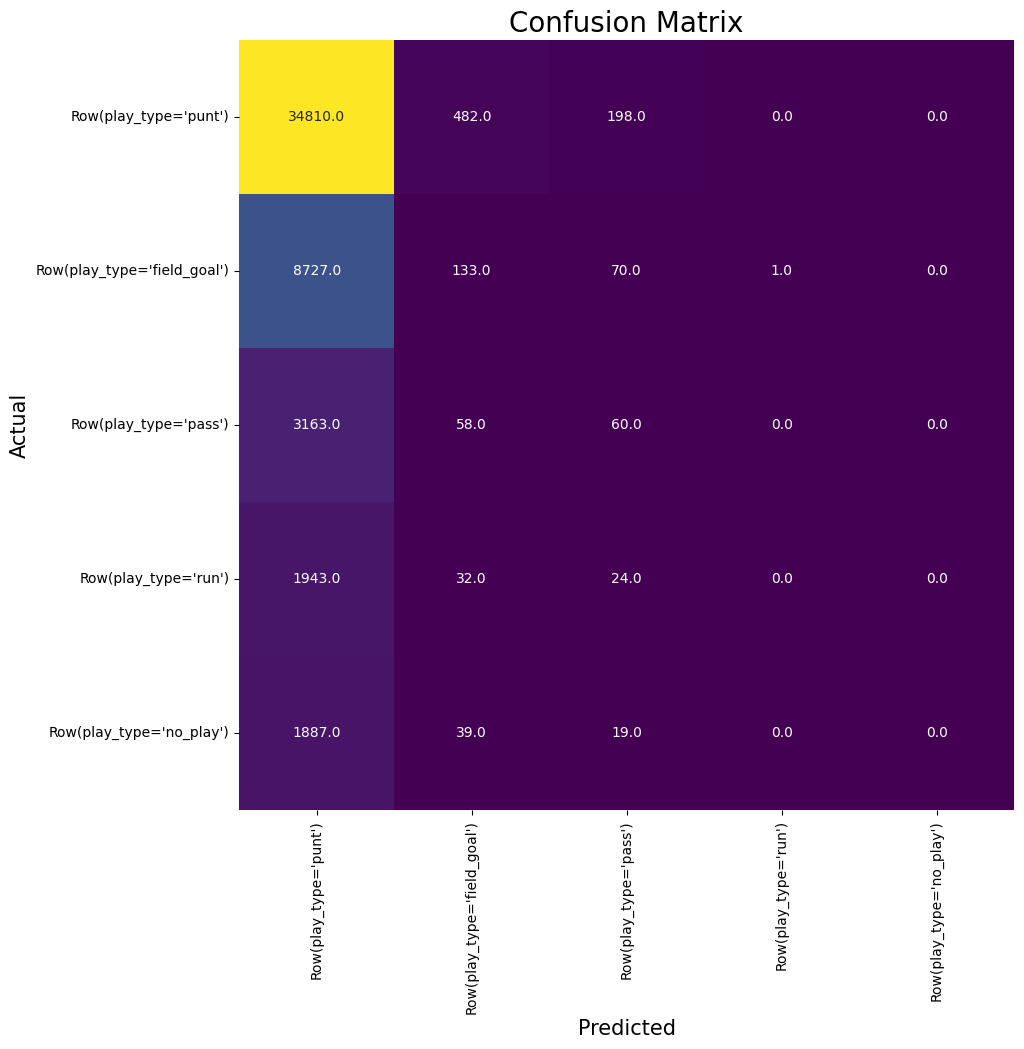

In [35]:
# labels = ["field_goal", "no_play", "pass", "punt", "run"]
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15

### Conclusions

Some quick observations:

* Much better performance when we don't undersample, could be because everything is a punt
* We need to be careful with the labels for the confusion matrix. They were not intially lining up properly with what the idxs are.
* I added temp, wind, roof, surface to the predictors